# Improving the Performance of Machine Learning Predictors


### Questions:


- How may we improve upon the performance of a machine learning classifier that does not perform so well?

- How may we pick the most relevant data points that are related to the class of a sample?

- Can we also train a deep learning predictor to tell proteins apart?

### Objectives:
    

- Practise machine learning optimisation techniques including GridSearchCV and dimensionality reduction


- Practise prediction by applying a deep learning model to the problem and evaluating its performance



When a machine learning predictor is performing well, there is always the possibility of improving its performance. This second part of the exercise will focus on techniques to achieve this performance increase. The first method we will explore is model hyperparameterisation. This means editing the model's parameters until a maximum score and optimisation are reached. Secondly we can increase performance by selecting features in the data which can allow patterns to be more easily trained upon, thus reducing the signal to noise ratio in the data. Finally, we will look at combining features with dimensionality reduction.

In [3]:
##Get Encodings###
import sys
import pandas as pd
from pandas import read_csv
sys.path.append('../src/')
sys.path.append('')
from Bio import SeqIO
#from propythia.sequence import ReadSequence
#sequence=ReadSequence()
#from propythia.descriptors import Descriptor


##Data preparation###
from sklearn.utils import check_random_state, shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
import numpy as np
from numpy import pi, linspace, cos, sin, append, ones, zeros, hstack, vstack, intp
from numpy import mgrid, linspace, c_, arange, mean, array
from numpy.random import uniform, seed



##Machine Learning Models###
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation


##Plotting Results###
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits import mplot3d
from matplotlib.pyplot import subplots, axes, scatter, xticks
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef


##Model Optimisation###
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


In [6]:
##Get variables##
joined_dataframe_VH_VL = read_csv('./HumanMouseOAS_VH_VL_paired_data.faa_Full_descriptors.csv', header = 0)
RANDOM_SEED = 0
#Prepare training data and labels
labels1 = 1000*[1] ##Human antibodies will be class 1
labels2 = 1000*[0] ## Mouse antibodies will be class 0
y = labels1+labels2
dataset = joined_dataframe_VH_VL
dataset=dataset.loc[:, dataset.columns != 'Unnamed: 0']
classifiers = {
    'SVC':SVC(kernel="linear", C=0.025),
    'SVC2': SVC(gamma=2, C=1),
    'DecisionTree': DecisionTreeClassifier(max_depth=5),
    'RFC': RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    'MLPC': MLPClassifier(alpha=1, max_iter=1000,random_state=42),
    'ADABoost':AdaBoostClassifier(),
    'GaussianNB': GaussianNB(),
    'QDA':QuadraticDiscriminantAnalysis(),
}



X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=.3, random_state=RANDOM_SEED, shuffle=True)
num_rows, num_cols = dataset.shape
print("Training set size: ", X_train.shape, "       Test set size: ", X_test.shape)
scores = []

for i in classifiers:
    clf_1 = classifiers.get(i)
    clf_1.fit(X_train,y_train)
    y_predict1 = clf_1.predict(X_test)
    scoring = matthews_corrcoef(y_test, y_predict1)
    scores.append(scoring) 



Training set size:  (1400, 890)        Test set size:  (600, 890)


/Users/james/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


## GridSearchCV
This is usually done through either GridSearchCV, which does this using a reference grid and systematically compares each combination with every other; or RandomSearchCV - which is more stochastic and, instead, samples from ranges which may be applied to each parameter. Here we will apply the GridSearchCV on both the SVC2 and RandomForestClassifier predictor, in order to try and increase its performance on our dataset.

It is important to know that not all classifiers have the capacity for GridSearchCV.

N.B. These processes will likely take a few minutes.

In [3]:
##GridsearchCV of SVC2 Model####
param_grid = {'C':[1],
              'gamma':[1,0.001],
}

svc = SVC()
svc_grid_search = GridSearchCV(estimator = svc, param_grid=  param_grid,
                               refit = True, n_jobs = -1,verbose = 2)
svc_grid_search.fit(X_train,y_train)


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[CV] END .......................................C=1, gamma=1; total time=   1.4s
[CV] END .......................................C=1, gamma=1; total time=   1.4s
[CV] END ...................................C=1, gamma=0.001; total time=   1.4s
[CV] END .......................................C=1, gamma=1; total time=   1.5s
[CV] END ...................................C=1, gamma=0.001; total time=   1.4s
[CV] END .......................................C=1, gamma=1; total time=   1.4s
[CV] END .......................................C=1, gamma=1; total time=   1.5s
[CV] END ...................................C=1, gamma=0.001; total time=   1.4s
[CV] END ...................................C=1, gamma=0.001; total time=   0.6s
[CV] END ...................................C=1, gamma=0.001; total time=   0.6s


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1], 'gamma': [1, 0.001]}, verbose=2)

In [4]:
##GridsearchCV of MLPC Model####

param_grid = {
    'activation': ['tanh', 'relu'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
# Create a based model
mlpc = MLPClassifier()
# Instantiate the grid search model
mlpc_grid_search = GridSearchCV(estimator = mlpc, param_grid = param_grid, 
                          refit = True, cv = 3, n_jobs = -1, verbose = 2)
mlpc_grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END activation=tanh, alpha=0.0001, learning_rate=adaptive; total time=   0.6s
[CV] END activation=tanh, alpha=0.0001, learning_rate=constant; total time=   0.7s
[CV] END activation=tanh, alpha=0.05, learning_rate=constant; total time=   0.7s
[CV] END activation=tanh, alpha=0.0001, learning_rate=constant; total time=   0.8s
[CV] END activation=tanh, alpha=0.05, learning_rate=constant; total time=   0.7s
[CV] END activation=tanh, alpha=0.0001, learning_rate=adaptive; total time=   0.8s
[CV] END activation=tanh, alpha=0.0001, learning_rate=adaptive; total time=   0.9s
[CV] END activation=tanh, alpha=0.0001, learning_rate=constant; total time=   1.5s
[CV] END activation=tanh, alpha=0.05, learning_rate=constant; total time=   0.9s
[CV] END activation=tanh, alpha=0.05, learning_rate=adaptive; total time=   0.9s
[CV] END activation=tanh, alpha=0.05, learning_rate=adaptive; total time=   1.0s
[CV] END activation=tanh, alpha=0.05,

GridSearchCV(cv=3, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'learning_rate': ['constant', 'adaptive']},
             verbose=2)

In [5]:
##GridsearchCV of QDA Model####

param_grid = {'reg_param': [0.1, 0.2, 0.3, 0.4, 0.5]}
# Create a based model
qda = QuadraticDiscriminantAnalysis()
# Instantiate the grid search model
qda_grid_search = GridSearchCV(estimator = qda, param_grid = param_grid, 
                          refit = True, cv = 3, n_jobs = -1, verbose = 2)
qda_grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


/Users/james/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/james/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/james/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/james/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/james/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/james/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variab

[CV] END ......................................reg_param=0.1; total time=   0.4s
[CV] END ......................................reg_param=0.3; total time=   0.3s
[CV] END ......................................reg_param=0.3; total time=   0.3s
[CV] END ......................................reg_param=0.1; total time=   0.4s
[CV] END ......................................reg_param=0.1; total time=   0.4s
[CV] END ......................................reg_param=0.2; total time=   0.4s
[CV] END ......................................reg_param=0.2; total time=   0.4s
[CV] END ......................................reg_param=0.2; total time=   0.4s


/Users/james/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/james/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/james/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/james/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/james/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/james/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variab

[CV] END ......................................reg_param=0.4; total time=   0.3s
[CV] END ......................................reg_param=0.4; total time=   0.3s
[CV] END ......................................reg_param=0.3; total time=   0.3s
[CV] END ......................................reg_param=0.5; total time=   0.3s
[CV] END ......................................reg_param=0.4; total time=   0.3s
[CV] END ......................................reg_param=0.5; total time=   0.3s
[CV] END ......................................reg_param=0.5; total time=   0.3s


/Users/james/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


GridSearchCV(cv=3, estimator=QuadraticDiscriminantAnalysis(), n_jobs=-1,
             param_grid={'reg_param': [0.1, 0.2, 0.3, 0.4, 0.5]}, verbose=2)

Let's plot some additional confusion matrices to check if these classifiers are working better after GridsearchCV

{'C': 1, 'gamma': 0.001}


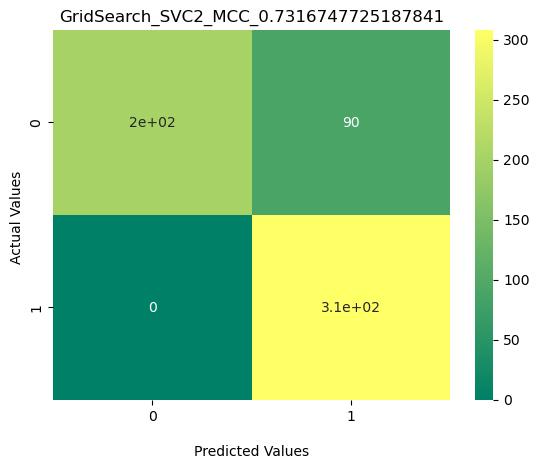

In [6]:
##Plot SVC GRID SEARCH CONFUSION MATRIX###
print(svc_grid_search.best_params_) ##Print the parameters which achieved the best score
y_predict1 = svc_grid_search.predict(X_test)
svc_grid_search_scoring = matthews_corrcoef(y_test, y_predict1)
cf_matrix1 = metrics.confusion_matrix(y_test, y_predict1)
ax1 = sns.heatmap(cf_matrix1, annot=True, cmap='summer')
title = str("GridSearch_SVC2_MCC_"+str(svc_grid_search_scoring))
ax1.set_title(title);
ax1.set_xlabel('\nPredicted Values')
ax1.set_ylabel('Actual Values ');
plt.show()

{'activation': 'relu', 'alpha': 0.0001, 'learning_rate': 'adaptive'}


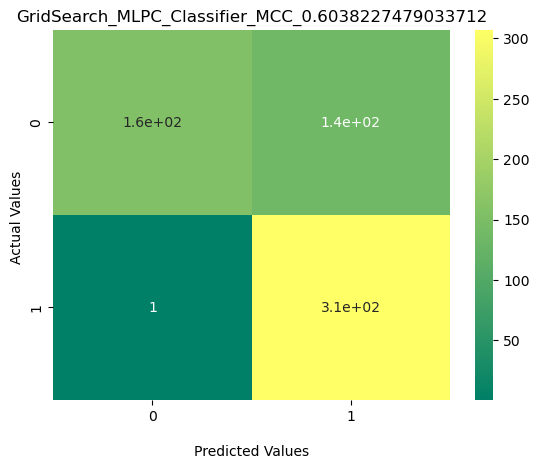

In [7]:
##Plot MLPC GRID SEARCH CONFUSION MATRIX###

print(mlpc_grid_search.best_params_) ##Print the parameters which achieved the best score
y_predict1 = mlpc_grid_search.predict(X_test)
mlpc_grid_search_scoring = matthews_corrcoef(y_test, y_predict1)
cf_matrix1 = metrics.confusion_matrix(y_test, y_predict1)
ax1 = sns.heatmap(cf_matrix1, annot=True, cmap='summer')
title = str("GridSearch_MLPC_Classifier_MCC_"+str(mlpc_grid_search_scoring))
ax1.set_title(title);
ax1.set_xlabel('\nPredicted Values')
ax1.set_ylabel('Actual Values ');
plt.show()

{'reg_param': 0.1}


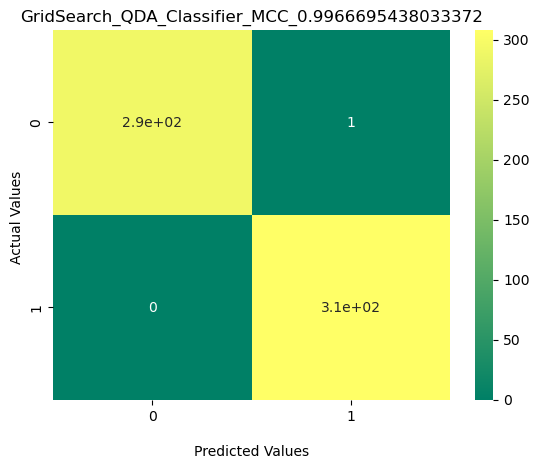

In [8]:
##Plot MLPC GRID SEARCH CONFUSION MATRIX###

print(qda_grid_search.best_params_) ##Print the parameters which achieved the best score
y_predict1 = qda_grid_search.predict(X_test)
qda_grid_search_scoring = matthews_corrcoef(y_test, y_predict1)
cf_matrix1 = metrics.confusion_matrix(y_test, y_predict1)
ax1 = sns.heatmap(cf_matrix1, annot=True, cmap='summer')
title = str("GridSearch_QDA_Classifier_MCC_"+str(qda_grid_search_scoring))
ax1.set_title(title);
ax1.set_xlabel('\nPredicted Values')
ax1.set_ylabel('Actual Values ');
plt.show()

We can also compare the old MCC score to the new one and see how they have improved for ourselves.

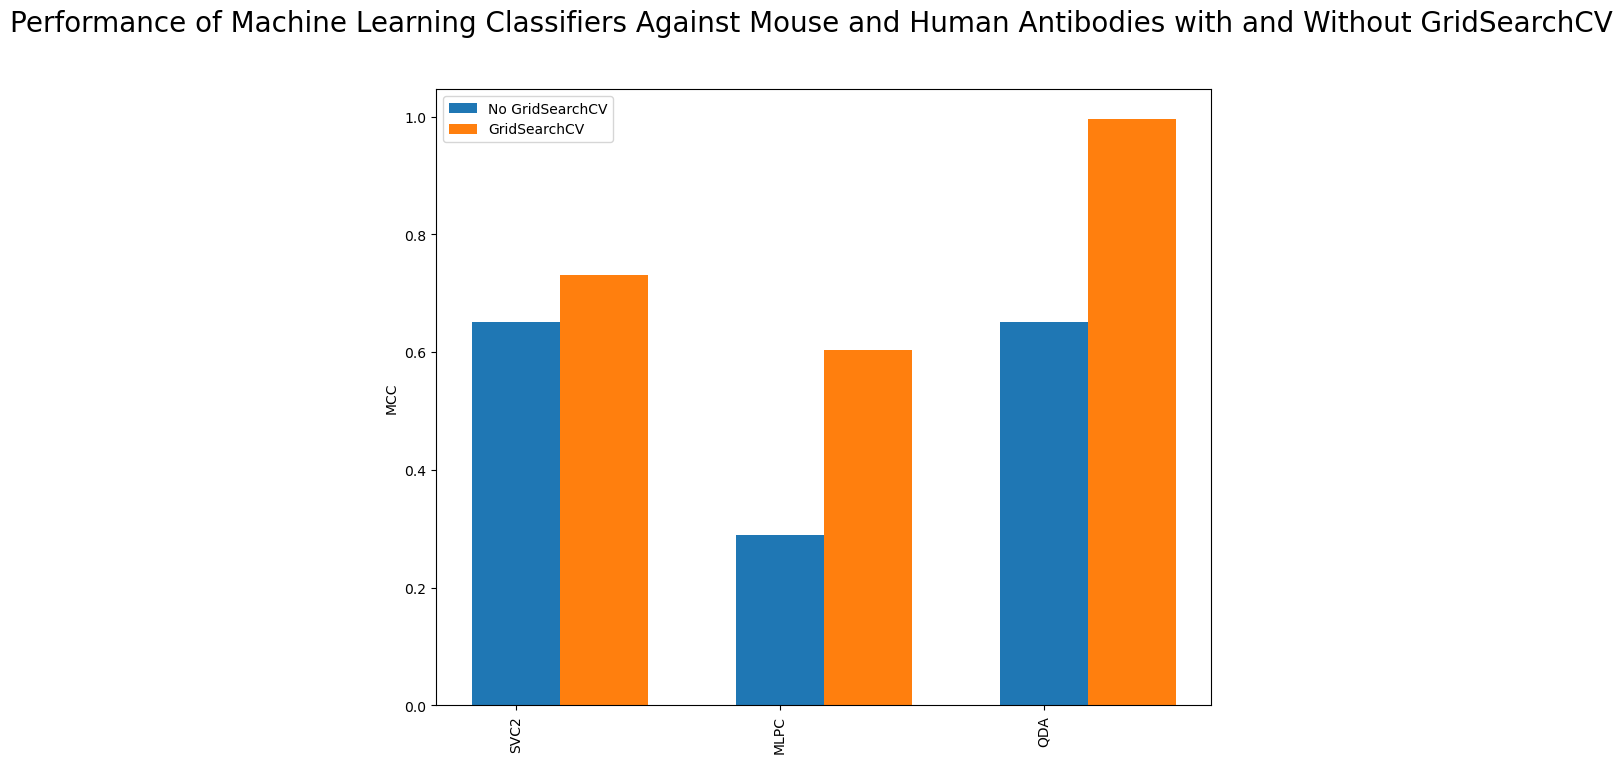

In [9]:
##Plot MCC values of SVC and RFC Models with and without GridsearchCV##
import numpy as np 
import matplotlib.pyplot as plt

classifiers2 = ["SVC2","MLPC","QDA"]
no_grid_scores = [scores[1],scores[4],scores[7]]
grid_scores = [svc_grid_search_scoring, mlpc_grid_search_scoring,qda_grid_search_scoring] 
labels = classifiers2
aranged = np.arange(len(classifiers2)) 
width = 1/3

fig, ax = plt.subplots(figsize=(10,8))


bar1 = plt.bar(aranged, no_grid_scores, width,label = 'No GridSearchCV')
bar2 = plt.bar(aranged+width, grid_scores , width,label = 'GridSearchCV')

plt.suptitle('Performance of Machine Learning Classifiers Against Mouse and Human Antibodies with and Without GridSearchCV', fontsize=20)
ax.set_ylabel('MCC')
ax.set_xticks(aranged, labels, rotation = 90)
ax.legend()


plt.legend()
plt.show()

We can see that the performance of all of the classifiers have changed,which was positive for the SVC2 and QDA classifiers, but not for the MLPC classifier. This may be that the default parameters work better than any of the additionally tested parameters. Bear this in mind when trying GridSearchCV in future.

GB: a systematic grid search should not get worse if the original parameters are included. 


## Do it yourself

- GridSearchCV is not the only kind of hyperparameter optimisation technique. RandomizedSearchCV is similar to GridSearchCV but instead of iterating over every combination of specified parameter, it randomly samples intervals for for a given number of iterations and notes which settings score the best. Documentation can be found here: https://scikit-learn.org/stable/supervised_learning.html

- Try optimising the MLPC with RandomizedSearchCV instead and see if this improves performance.

## Feature Importance

Some classifiers have functions where features with high importance can be ranked. A Random Forest Classifier has a feature importance instance, where the features that contribute most highly to the determination of the classifier may be examined and plotted as percentages of their contribution. Using the best hyperparameters found by the GridSearchCV alogrithm, we may declare a new Random Forest and investigate which features are the most significant.


/var/folders/r7/969c1s5942x9xn1z91z7rvgw0000gn/T/ipykernel_65130/1769456946.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sorted_feature_names[:49], rotation=-90);


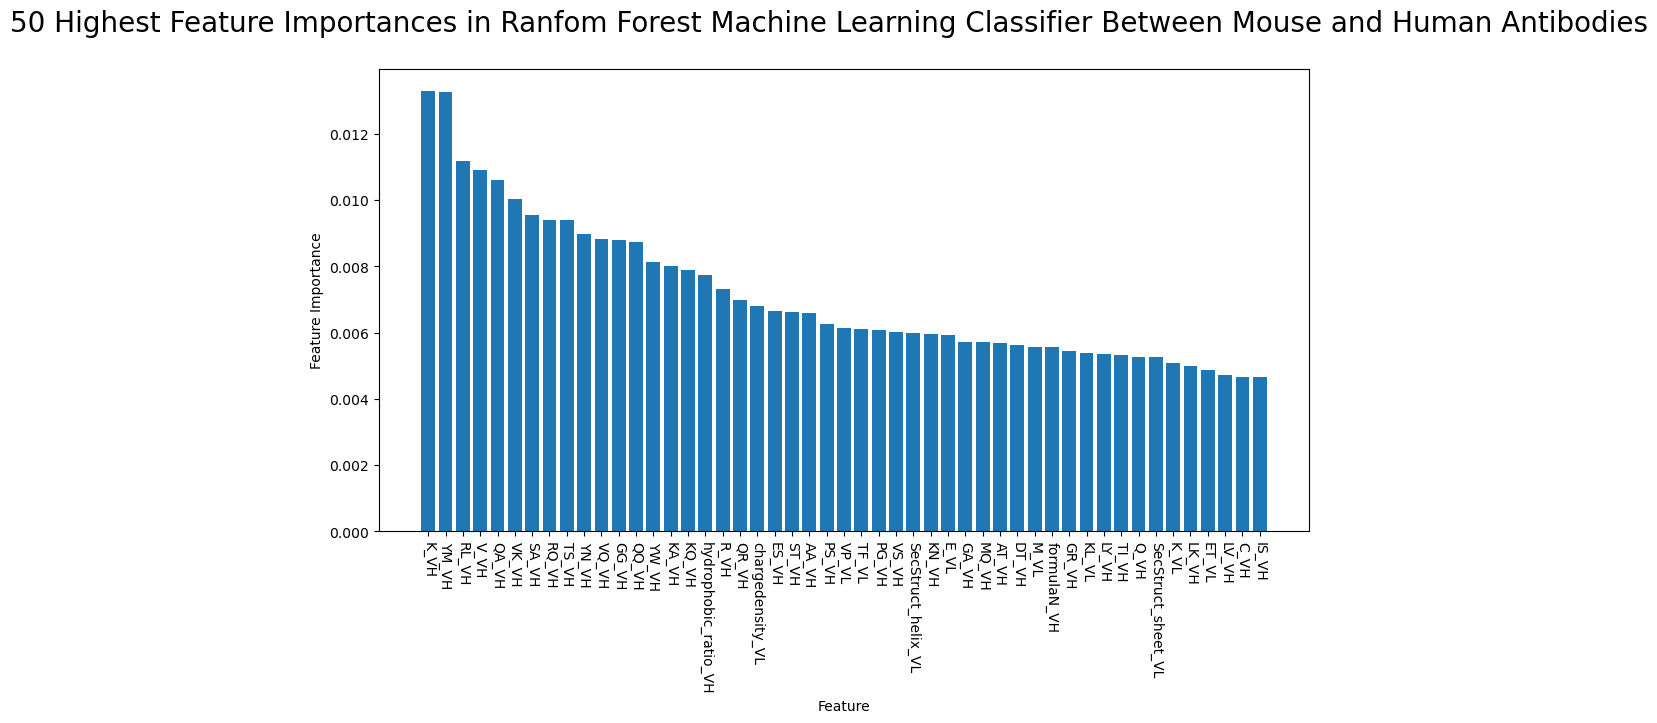

In [10]:
##Get Feature Importance from RFC Model and Plot Top 50 Features###
RF_Best_Params = RandomForestClassifier(bootstrap= True, max_depth=80, max_features=3, min_samples_leaf= 3, min_samples_split= 10, n_estimators= 100)
RF_Best_Params.fit(X_train, y_train)
importances  =  RF_Best_Params.feature_importances_
sorted_importances = sorted(importances, reverse=True)
feature_names = X_train.columns
sorted_feature_names = [feature_names for _, feature_names in sorted(zip(importances, feature_names), reverse = True)]
fig, ax = plt.subplots(figsize=(12,6))

plt.suptitle('50 Highest Feature Importances in Ranfom Forest Machine Learning Classifier Between Mouse and Human Antibodies', fontsize=20)
ax.bar(sorted_feature_names[:49], sorted_importances[:49])
ax.set_ylabel('Feature Importance')
ax.set_xlabel('Feature')
ax.set_xticklabels(sorted_feature_names[:49], rotation=-90);
plt.show()

While this has now selected the features which have been most important for prediction, because these are features not explained by the encoding method, it is difficult to see how these relate to the sequences themselves. Perhaps using this technique on a simpler encoding could actually identify residues which are important for distinguishing mouse and human antibodies?


/var/folders/r7/969c1s5942x9xn1z91z7rvgw0000gn/T/ipykernel_9479/1162206905.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sorted_feature_names[:49], rotation=-90);


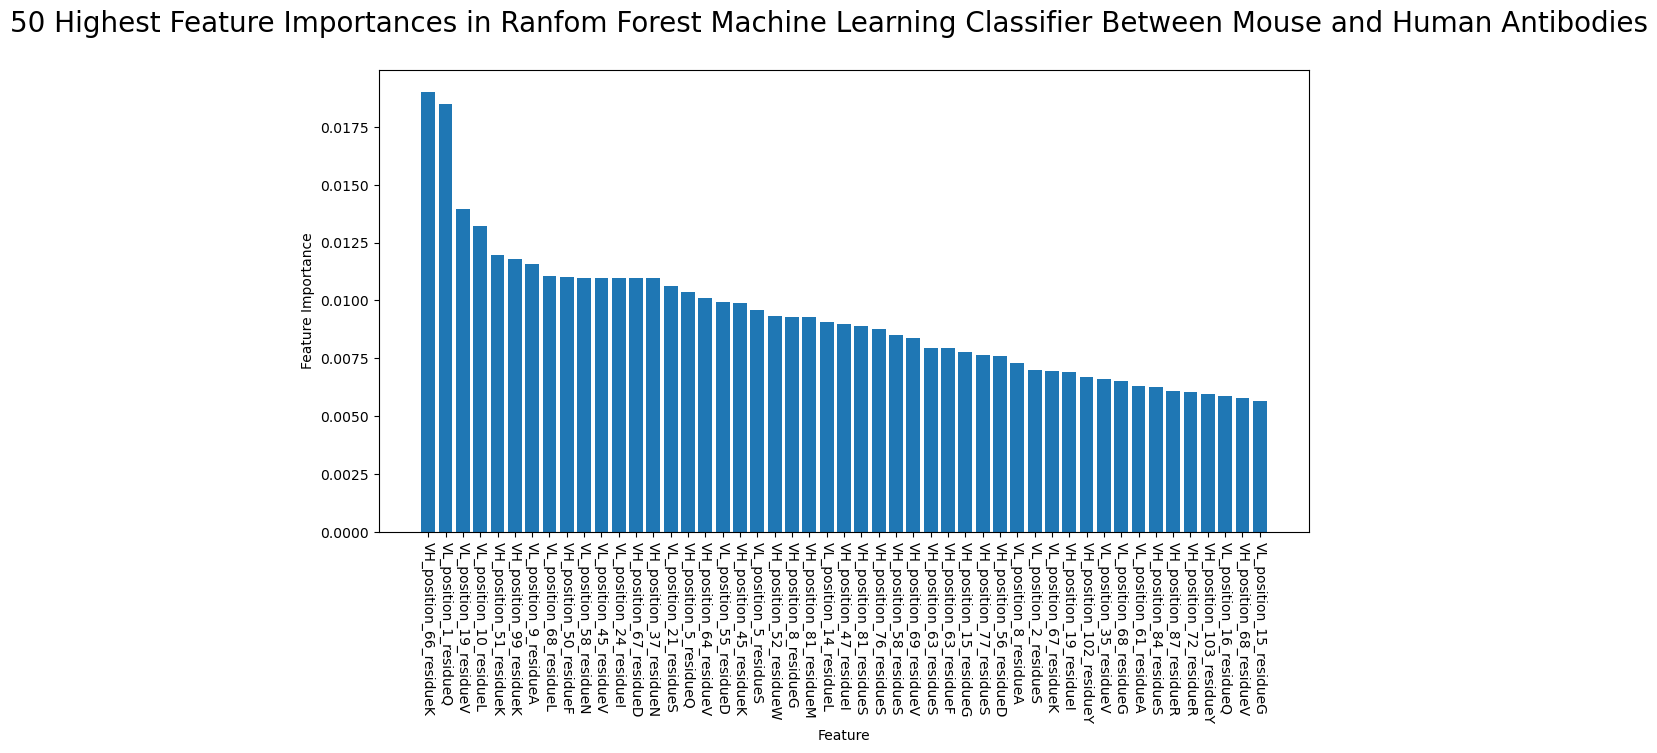

In [16]:

OHE_joined_dataframe_VH_VL = read_csv('./Human_Mouse_VH_VL_OHE.csv',header=0)
X_train_OHE, X_test_OHE, y_train_OHE, y_test_OHE = train_test_split(OHE_joined_dataframe_VH_VL, y, test_size=.3, random_state=RANDOM_SEED, shuffle=True)

##Get Feature Importance from RFC Model and Plot Top 50 Features###
RF_Best_Params = RandomForestClassifier(bootstrap= True, max_depth=80, max_features=3, min_samples_leaf= 3, min_samples_split= 10, n_estimators= 100)
RF_Best_Params.fit(X_train_OHE, y_train_OHE)
importances  =  RF_Best_Params.feature_importances_
sorted_importances = sorted(importances, reverse=True)
feature_names = OHE_joined_dataframe_VH_VL.columns
sorted_feature_names = [feature_names for _, feature_names in sorted(zip(importances, feature_names), reverse = True)]
fig, ax = plt.subplots(figsize=(12,6))

plt.suptitle('50 Highest Feature Importances in Ranfom Forest Machine Learning Classifier Between Mouse and Human Antibodies', fontsize=20)
ax.bar(sorted_feature_names[:49], sorted_importances[:49])
ax.set_ylabel('Feature Importance')
ax.set_xlabel('Feature')
ax.set_xticklabels(sorted_feature_names[:49], rotation=-90);
plt.show()

These features give a more clear view on what information is being considered by the model as the most important for determining if a given antibody is mouse or human. However, as can be seen, the relative feature importance scores are still particularly low, indicating that no single feature can definitively determine this, and so a number of features have to be taken into account. Does the performance improve if we just use the most important features?

## Do it yourself
We now have a list of all the feature names sorted by feature importance. By using the code below we can rework our dataframe to the 50 most important features:

`X = X[sorted_feature_names][:49]`

- Try running the classifiers again, but this time use the top 50 features only as your input data. See how that improves each classifier. Are all of them improved?


## Dimensionality Reduction

As an additional task, we can try dimensionality reduction in the event that it might improve the performance of poorer predictors. Principal Component Analysis (PCA) is commonly applied in machine learning as a pre-processing step when dealing with data that contains multiple data points per sample. This increases interpretability of our data, and also allows us to plot it, visually. In short, it works to identify data points that can be grouped together and represented in a vector (principal components) to explain the variability seen in the data. Usually, they are ordered in descending order of how much variability they can explain (e.g. PC1 would explain the most variability, PCn would explain the least).

We can then apply PCA to our dataset, and see if this changes the performance of our predictors.




In [21]:
##Perform PCA 
nComp = 50 # Number of PCs to be returned

threshold = 0.999999


EncodingPCA = PCA(n_components=nComp, whiten=True)
EncodingPCA = EncodingPCA.fit(dataset)

cumExpVar = np.cumsum(EncodingPCA.explained_variance_ratio_)
keepPC = [pc for pc in range(nComp) if cumExpVar[pc]>=threshold][0]

NewEncodingPCA = EncodingPCA.transform(dataset)[:,range(keepPC)]
print(NewEncodingPCA.shape)



(2000, 25)


In [25]:
print(NewEncodingPCA.shape)

##Train/Test Split##
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(NewEncodingPCA, y, test_size=.3, random_state=RANDOM_SEED, shuffle=True)
num_rows, num_cols = dataset.shape
print("Training set size: ", X_train_PCA.shape, "       Test set size: ", X_test_PCA.shape)


(2000, 25)
Training set size:  (1400, 25)        Test set size:  (600, 25)


In [26]:
##Loop through classifiers and obtain MCC values of new datasets##
scores_PCA = []
for i in classifiers:
    clf_1 = classifiers.get(i)
    clf_1.fit(X_train_PCA,y_train_PCA)
    y_predict1 = clf_1.predict(X_test_PCA)
    scoring = matthews_corrcoef(y_test_PCA, y_predict1)
    scores_PCA.append(scoring)


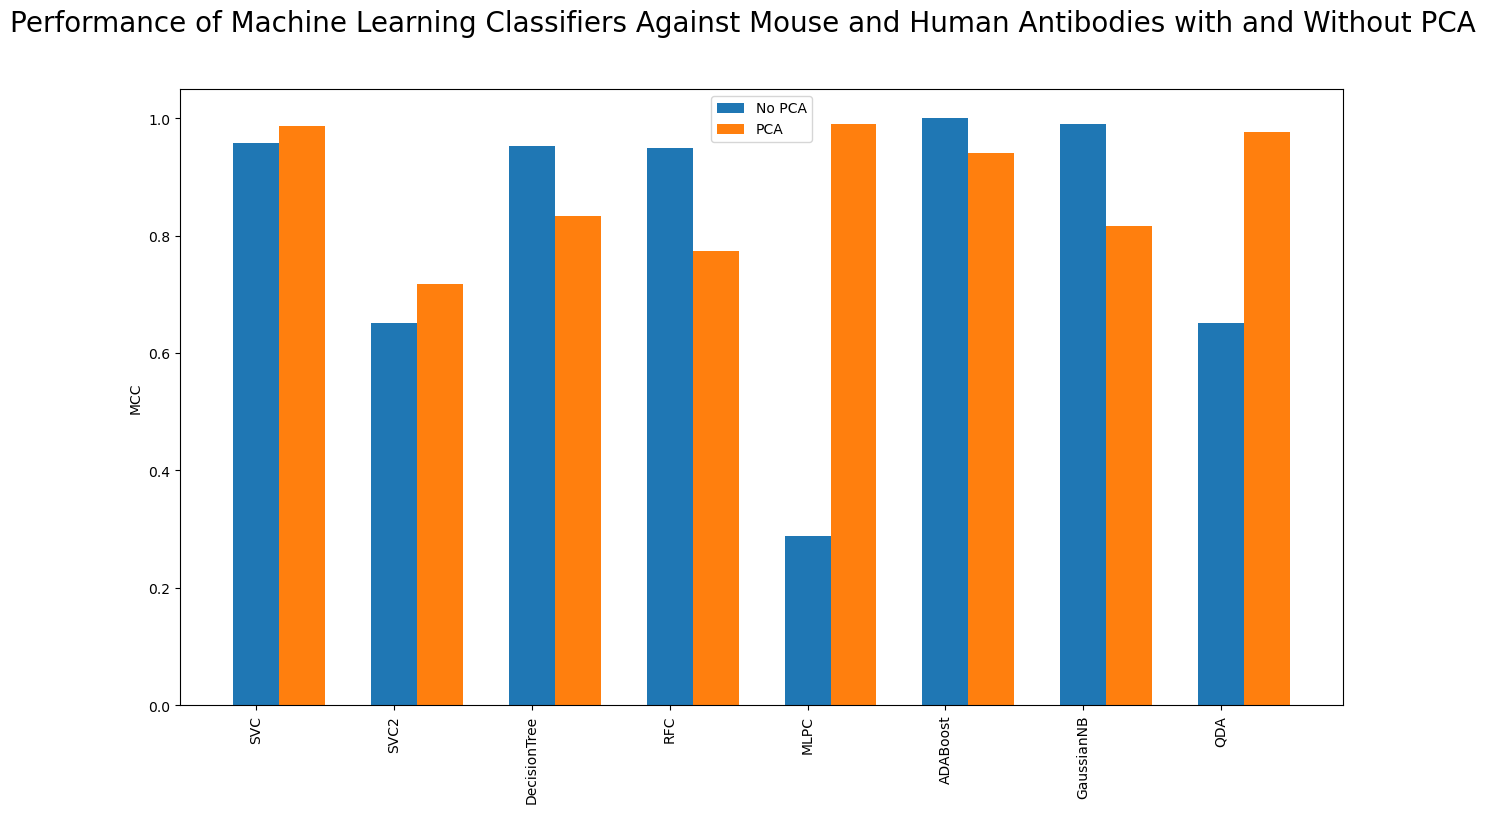

In [27]:
##Plot Score of Each Classifier Comparing Dataset with PCA and without PCA##
import numpy as np 
import matplotlib.pyplot as plt 
labels = list(classifiers.keys())
aranged = np.arange(len(classifiers)) 
width = 1/3
fig, ax = plt.subplots(figsize=(15,8))

bar1 = plt.bar(aranged, scores, width,label = 'No PCA')
bar2 = plt.bar(aranged+width, scores_PCA , width,label = 'PCA')
plt.suptitle('Performance of Machine Learning Classifiers Against Mouse and Human Antibodies with and Without PCA', fontsize=20)
ax.set_ylabel('MCC')
ax.set_xticks(aranged, labels, rotation = 90)
ax.legend()


plt.legend()
plt.show()

We see that some classifiers improve performance (SVC, MLPC,QDA) with the PCA but this is not always the case (Decision Tree, RFC, ADABoost). 

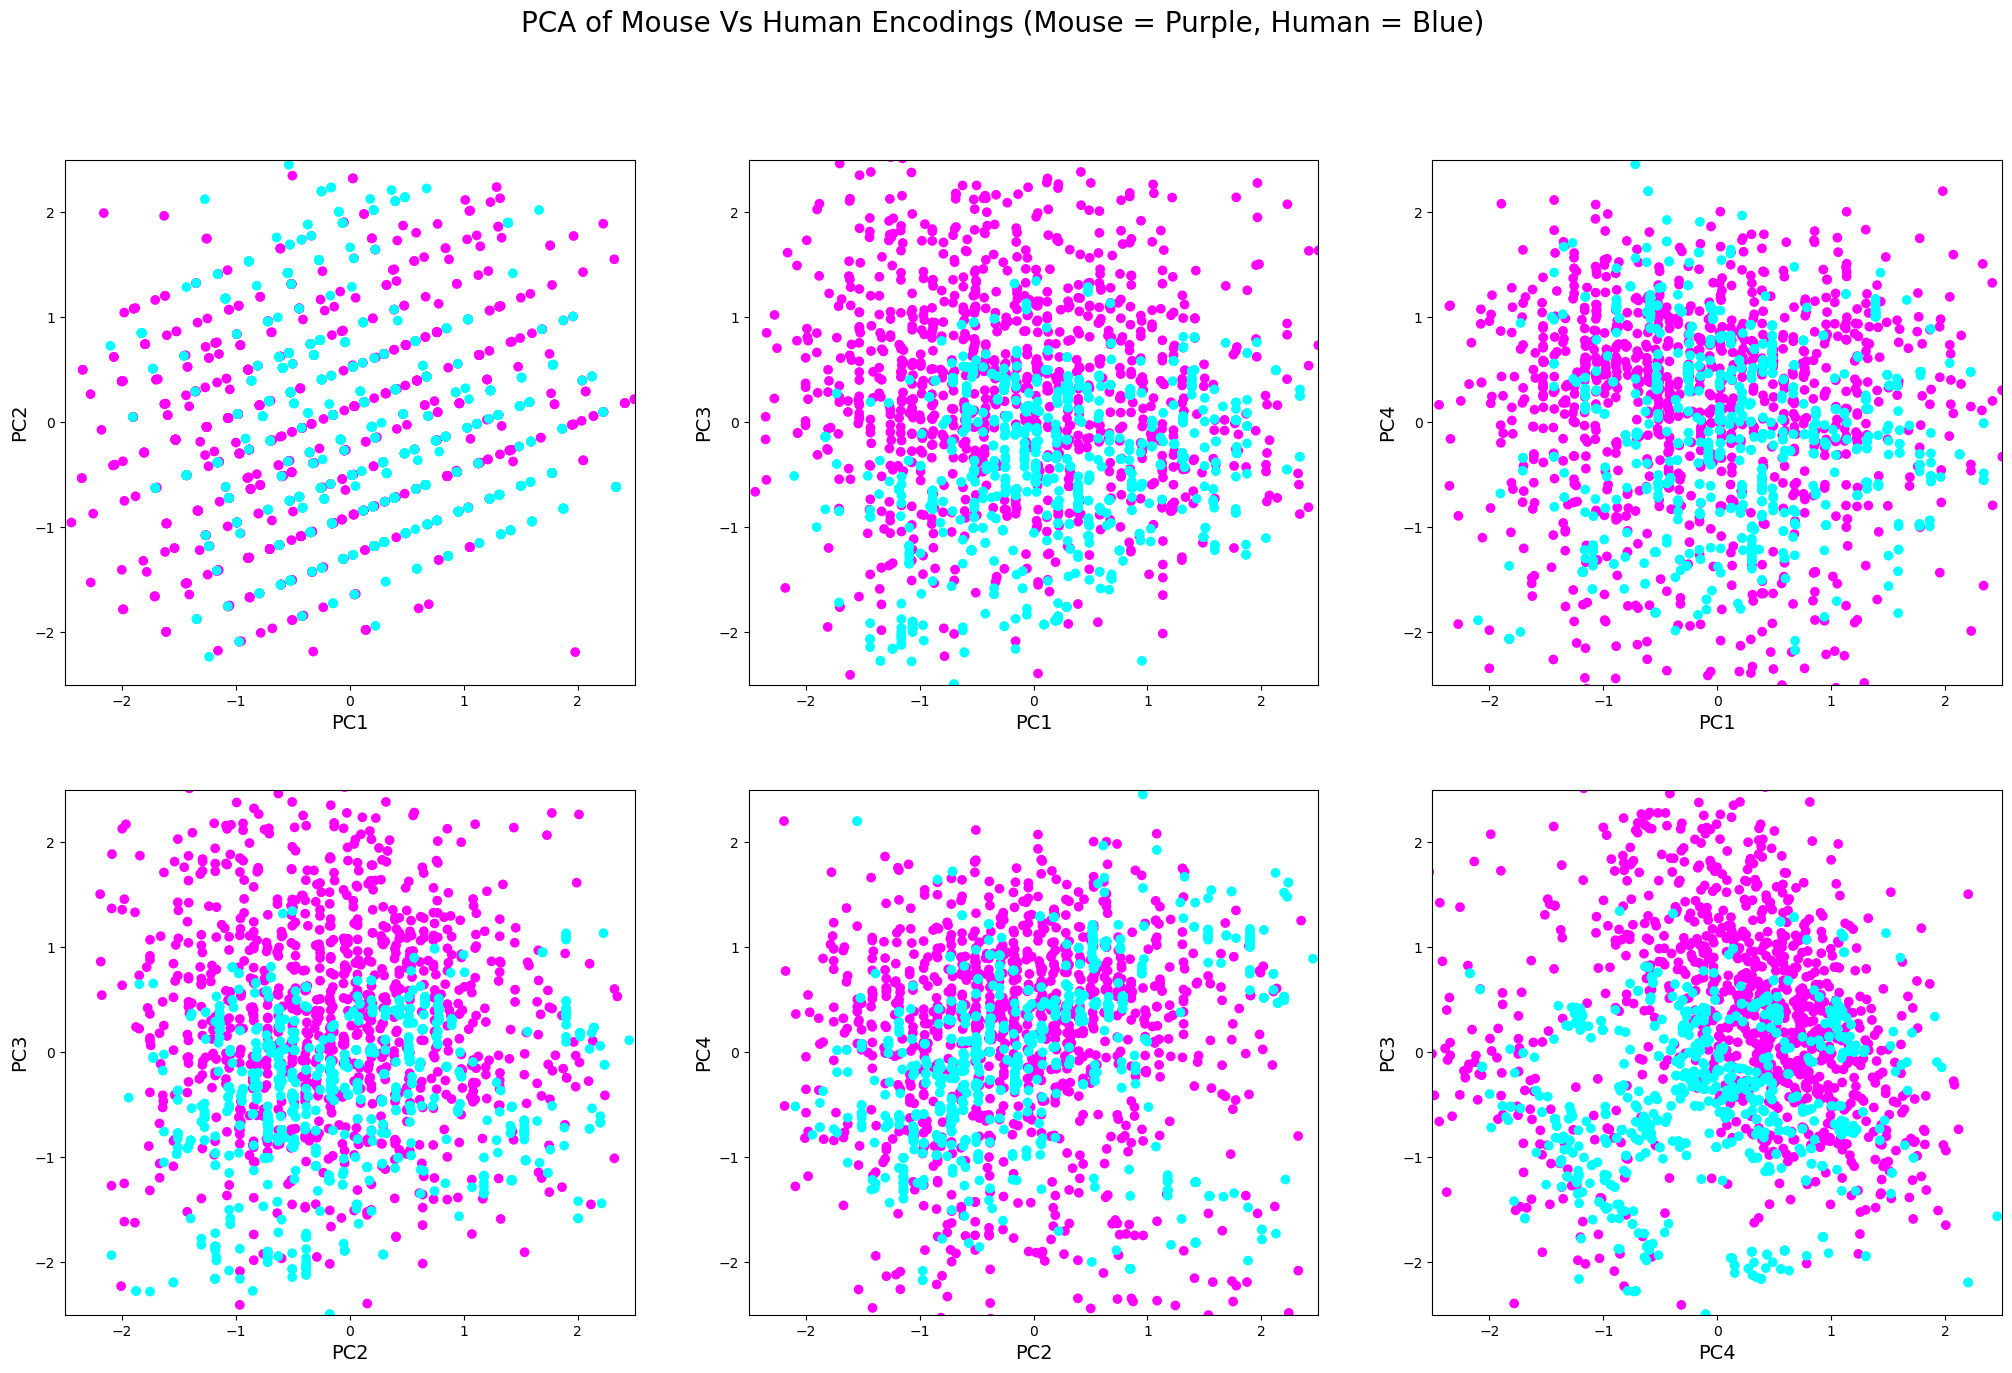

In [15]:
##Visualising Data Plot##
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(25, 15))
plt.suptitle('PCA of Mouse Vs Human Encodings (Mouse = Purple, Human = Blue)', fontsize=20)

ax[0, 0].scatter(NewEncodingPCA[:,0], NewEncodingPCA[:,1], c=y, cmap='cool');
ax[0, 0].set_xlabel('PC1', fontsize=14); ax[0, 0].set_xlim([-2.5,2.5]);
ax[0, 0].set_ylabel('PC2', fontsize=14); ax[0, 0].set_ylim([-2.5,2.5]);


ax[0, 1].scatter(NewEncodingPCA[:,0], NewEncodingPCA[:,2], c=y, cmap='cool');
ax[0, 1].set_xlabel('PC1', fontsize=14); ax[0, 1].set_xlim([-2.5,2.5]);
ax[0, 1].set_ylabel('PC3', fontsize=14); ax[0, 1].set_ylim([-2.5,2.5]);


ax[0, 2].scatter(NewEncodingPCA[:,0], NewEncodingPCA[:,3], c=y, cmap='cool');
ax[0, 2].set_xlabel('PC1', fontsize=14); ax[0, 2].set_xlim([-2.5,2.5]);
ax[0, 2].set_ylabel('PC4', fontsize=14); ax[0, 2].set_ylim([-2.5,2.5]);


ax[1, 0].scatter(NewEncodingPCA[:,1], NewEncodingPCA[:,2], c=y, cmap='cool');
ax[1, 0].set_xlabel('PC2', fontsize=14); ax[1, 0].set_xlim([-2.5,2.5]);
ax[1, 0].set_ylabel('PC3', fontsize=14); ax[1, 0].set_ylim([-2.5,2.5]);


ax[1, 1].scatter(NewEncodingPCA[:,1], NewEncodingPCA[:,3], c=y, cmap='cool');
ax[1, 1].set_xlabel('PC2', fontsize=14); ax[1, 1].set_xlim([-2.5,2.5]);
ax[1, 1].set_ylabel('PC4', fontsize=14); ax[1, 1].set_ylim([-2.5,2.5]);


ax[1, 2].scatter(NewEncodingPCA[:,3], NewEncodingPCA[:,2], c=y, cmap='cool');
ax[1, 2].set_xlabel('PC4', fontsize=14); ax[1, 2].set_xlim([-2.5,2.5]);
ax[1, 2].set_ylabel('PC3', fontsize=14); ax[1, 2].set_ylim([-2.5,2.5]);




We can see here that the graphs showing PC1 against PC3 and PC2 against PC3 show some of the best separation between human and mouse antibodies. We can use this to support the trustworthiness of our dimensionality reduction technique.

## Do it yourself

We can use other methods of reducing the dimensionality of the dataset. F-regression is a technique that selects the n most relevant features to the target variable. It can be performed on the dataset like so:

~~~
from sklearn.feature_selection import SelectKBest`
from sklearn.feature_selection import f_regression
n = 100
X_NUMPY, Y_NUMPY = X.to_numpy(),y.to_numpy()
fs = SelectKBest(score_func=f_regression, k=n)
X_selected = fs.fit_transform(X_NUMPY, Y_NUMPY)
~~~

- Experiment with the n this method of dimensionality reduction on your data and see how the results compare to the Principle Component Analysis

## Using Deep Learning to Classify Human and Mouse Antibodies

Using deep learning to construct our own artificial neural network using Keras, we can implement a different tehcnique to the machine learning we have demonstrated, above. These networks are sophisticated algorithms built by the computer, and trained to best perform on the data in question. 

Outlined below, is a very simple model, compiled to act as a binary classifier for our dataset. We set this model to run over 20 epochs, which is a very short training run. By giving the model more epochs to train, it is possible to obrain better results; however there comes a point where the model will overfit to your data, and demonstrate poor prediction ability with any new data that is presented to it.

In [16]:
##Import Deep Learning Modules##
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding
import tensorflow as tf
from keras.callbacks import EarlyStopping


ModuleNotFoundError: No module named 'keras'

In [ ]:
#Initialising ANN##

X_train_np = np.asarray(X_train)
y_train_np = np.asarray(y_train)
X_test_np =  np.asarray(X_test)
y_test_np =  np.asarray(y_test)
print(X_train.shape)

ann = tf.keras.models.Sequential([tf.keras.layers.Dense(32, input_shape=(X_train.shape[1],)),
                                (tf.keras.layers.Dense(20,activation="relu")),
                                (tf.keras.layers.Dense(1,activation="sigmoid"))])

ann.compile(optimizer="adam",loss="binary_crossentropy",metrics=[tf.keras.metrics.BinaryAccuracy()])
#Fitting ANN
es = EarlyStopping(monitor='val_loss', mode='min', patience=200)
history = ann.fit(X_train_np,y_train_np,epochs = 2000, validation_data =(X_test_np,y_test_np), verbose = 0,callbacks=[es])
performance = ann.evaluate(X_test_np, y_test_np)


(1400, 890)
19/19 [==============================] - 0s 2ms/step - loss: 0.0526 - binary_accuracy: 0.9967


In [ ]:
##Get Final Score Prediction##
predict = ann.predict(X_test_np)
predict_binary = []
for x in predict:
    if x[0] > 0.5:
        predict_binary.append(1)
    elif x[0] < 0.5:
        predict_binary.append(0)
performance = ann.evaluate(X_test_np, y_test_np)
#print(performance)
MCC = matthews_corrcoef(y_test,predict_binary)
print(MCC)

19/19 [==============================] - 0s 2ms/step - loss: 0.0526 - binary_accuracy: 0.9967
0.9933285892190001


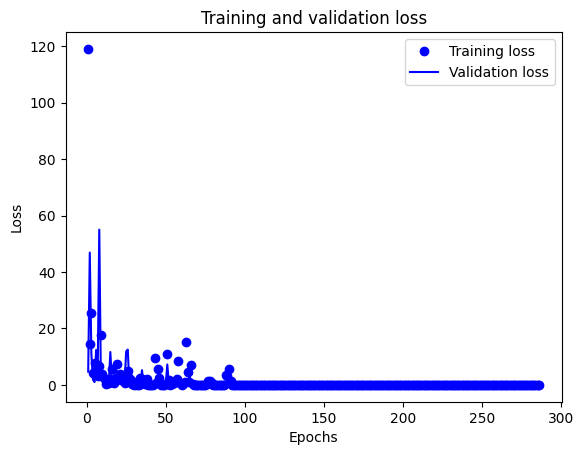

In [ ]:
##Plot Loss Function over Epochs##
history_dict = history.history
history_dict.keys()
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

We plot the loss function of the deep learning algorithm over the epochs we set it to. This measures how well the algorithm learns our datasets, and the patterns behind it. It is expected that the loss would decrease over time for both the training and validation data. In some scenarios, however, the loss function may increase over time; but this is usually indicative of model overfitting.

## End of Chapter Exercise

We have seen that it is possible to separate mouse and human antibody protein sequences through their numerical encodings. But what if we wanted to separate antibody sequences from more species? Included in this worksheet is a dataset of 1000 rat antibodies, as well as the previously used 1000-entry human and mouse datasets. On your own, try to generate additional classifieres to separate increasing combinations of species (*i.e.* human versus rat, and mouse versus rat). Use any of the hyperparameterisation techniques that we have learned, as you see fit. 

- Report which of these classifiers was the easiest to build.

- Give reasons why some of these classifiers may be difficult to build.

## Keypoints

- It is sometimes necessary to experiment with different machine learning classifiers or hyperparameterisation techniques, to achieve the best prediction results.

- Check the performance of your model with a "held back" dataset which was not included in the training set.

 